<a href="https://colab.research.google.com/github/dfmunoz11/Modelo_predictivo_SaberPro_2025/blob/main/03%20-%20modeloLgReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - modelo Logistic Regresion


In [1]:
# Configurar el entorno

!pip install -q kaggle pandas seaborn matplotlib

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score


In [3]:
# Cargar credenciales de Kaggle
# El archivo kaggle.json se carga desde el pc

from google.colab import files
files.upload() # <- Esta linea nos pide subir el archivo
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Descargar los datos

!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia
!mkdir -p data
!unzip -o udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip -d data

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 2.05GB/s]
Archive:  udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: data/submission_example.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [5]:
# Descargar los datos

print("Archivos en la carpeta data:")
!ls data

Archivos en la carpeta data:
submission_example.csv	test.csv  train.csv


In [6]:
# Carga del archivo train.csv

train_path = os.path.join("data", "train.csv")
df = pd.read_csv(train_path)

train_path_t = os.path.join("data", "test.csv")

print("Tamaño del dataset:", df.shape)
df.head()

Tamaño del dataset: (692500, 21)


,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [7]:

# 2. LIMPIEZA BÁSICA
# Eliminar columnas irrelevantes o con fuga de datos
cols_to_drop = ['ID', 'F_TIENEINTERNET.1', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
df = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

# Imputar valores faltantes en categóricas
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    if col != 'RENDIMIENTO_GLOBAL':
        df[col] = df[col].fillna('Desconocido')

# 3. CODIFICACIÓN DEL TARGET
print("\n--- Procesando Variable Objetivo ---")
valores_unicos = df['RENDIMIENTO_GLOBAL'].unique()
print(f"Valores encontrados: {valores_unicos}")

# MAPEO ACTUALIZADO
target_map = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
}

df['target'] = df['RENDIMIENTO_GLOBAL'].map(target_map)

# Verificar limpieza
df_clean = df.dropna(subset=['target']).copy()
df_clean['target'] = df_clean['target'].astype(int)
print(f"Dimensiones después de mapear el target: {df_clean.shape}")

if df_clean.shape[0] == 0:
    print("El DataFrame quedó vacío. Verifica el target_map contra los valores impresos arriba.")
else:
    # 4. PREPARACIÓN DE FEATURES (X)
    X_raw = df_clean.drop(['RENDIMIENTO_GLOBAL', 'target'], axis=1)
    y = df_clean['target']

    # One-Hot Encoding
    print("Aplicando One-Hot Encoding...")
    X = pd.get_dummies(X_raw, drop_first=True)
    print(f"Dimensiones finales de X: {X.shape}")

    # 5. DIVISIÓN TRAIN / TEST
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print(f"Datos divididos: Train {X_train.shape[0]}, Test {X_test.shape[0]}")

    # 6. ENTRENAMIENTO
    print("\n--- ENTRENANDO MODELOS ---")

    models = {
      "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    }

    results = []

for name, model in models.items():
      print(f"Entrenando {name}...")
      start = time.time()
      try:
          model.fit(X_train, y_train)
          preds = model.predict(X_test)

          acc = accuracy_score(y_test, preds)
          f1 = f1_score(y_test, preds, average='macro')

          results.append({'Modelo': name, 'Accuracy': acc, 'F1-Macro': f1, 'Tiempo (s)': time.time() - start})
      except Exception as e:
          print(f"Error en {name}: {e}")

    # 7. RESULTADOS
print("\n" + "="*40)
print("       RESULTADOS FINALES")
print("="*40)
print(pd.DataFrame(results).sort_values(by='F1-Macro', ascending=False))


--- Procesando Variable Objetivo ---
Valores encontrados: ['medio-alto' 'bajo' 'alto' 'medio-bajo']
Dimensiones después de mapear el target: (692500, 16)
Aplicando One-Hot Encoding...
Dimensiones finales de X: (692500, 1033)
Datos divididos: Train 484750, Test 207750

--- ENTRENANDO MODELOS ---
Entrenando Logistic Regression...

       RESULTADOS FINALES
                Modelo  Accuracy  F1-Macro   Tiempo (s)
0  Logistic Regression  0.409535  0.393312  1167.742422


--- CONFIGURANDO EL MODELO FINAL ---
Modelo Final cargado con los siguientes hiperparámetros:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

--- RENDIMIENTO FINAL (Test Set) ---
              precision    recall  f1-score   support

           0       0.43      0.54      0.48     51896
           1       0.32      0.23      0.27     51682
           2       0.31      0.24      0.27     51486
           3       0.50      0.62      0.56     52686

    accuracy                           0.41    207750
   macro avg       0.39      0.41      0.39    207750
weighted avg       0.39      0.41      0.39    207750


--- VARIABLES MÁS IMPORTANTES (Coeficientes para Regresión Logística) ---
                                                Feature  Importance
94    E_PR

/tmp/ipython-input-1852273127.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


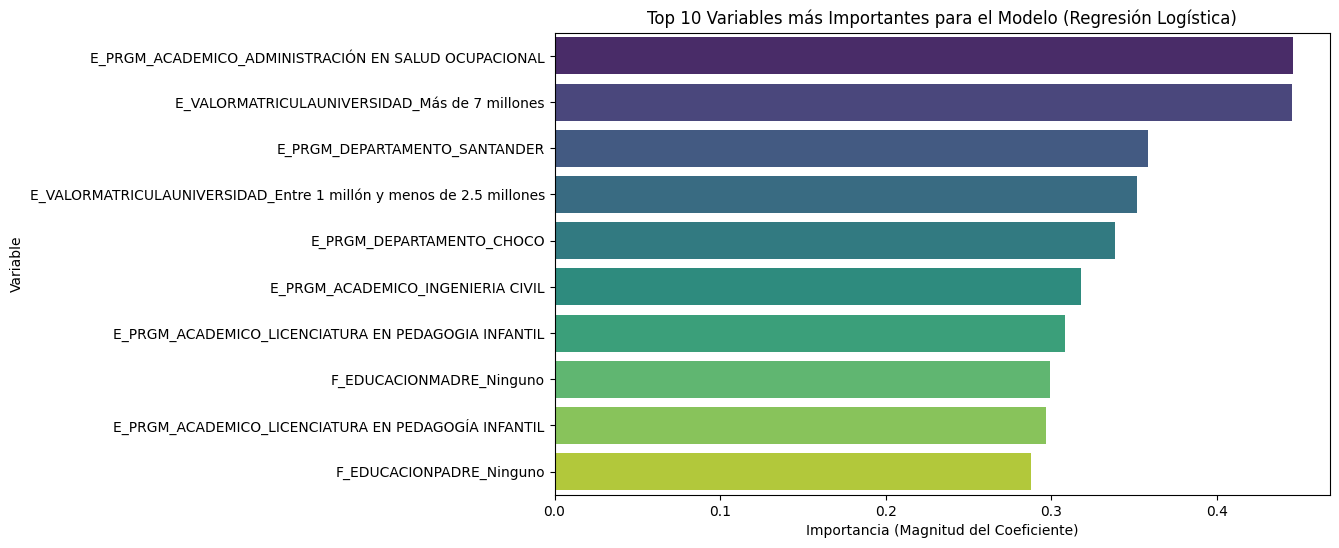


 ¡Modelo guardado exitosamente como 'modelo_saber_pro_optimizado.pkl'!
Ahora puedes usar este archivo para hacer predicciones en nuevos datos.


In [9]:
print("--- CONFIGURANDO EL MODELO FINAL ---")

# 1. RECUPERAR EL MODELO ENTRENADO
# Como solo se entrenó un modelo de Regresión Logística, lo asignamos directamente.
# Si se hubiera usado RandomizedSearchCV, se accedería a random_search.best_estimator_
final_model = models["Logistic Regression"]

print("Modelo Final cargado con los siguientes hiperparámetros:")
print(final_model.get_params())

# 2. EVALUACIÓN FINAL EN TEST
print("\n--- RENDIMIENTO FINAL (Test Set) ---")
y_pred_final = final_model.predict(X_test)
print(classification_report(y_test, y_pred_final))

# 3. Ver qué variables pesaron más en la decisión (Solo para modelos que lo permitan)

print("\n--- VARIABLES MÁS IMPORTANTES (Coeficientes para Regresión Logística) ---")

# Para Regresión Logística, se usan los coeficientes para determinar la importancia.
# Nota: La magnitud de los coeficientes indica importancia, el signo la dirección.
# Para una clasificación multiclase, `coef_` es un array de (n_classes, n_features).
# Podemos tomar el promedio de la magnitud o el valor absoluto para una importancia general.

if hasattr(final_model, 'coef_'):
    importances = np.mean(np.abs(final_model.coef_), axis=0)
    feature_names = X_train.columns

    # Crear DataFrame para visualizar
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Mostramos el Top 10
    print(feature_importance_df.head(10))

    # Gráfico del Top 10
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title('Top 10 Variables más Importantes para el Modelo (Regresión Logística)')
    plt.xlabel('Importancia (Magnitud del Coeficiente)')
    plt.ylabel('Variable')
    plt.show()
elif hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
    feature_names = X_train.columns

    # Crear DataFrame para visualizar
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Mostramos el Top 10
    print(feature_importance_df.head(10))

    # Gráfico del Top 10
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title('Top 10 Variables más Importantes para el Modelo')
    plt.xlabel('Importancia')
    plt.ylabel('Variable')
    plt.show()
else:
    print("El modelo no tiene atributos 'coef_' o 'feature_importances_' para determinar la importancia de las variables.")

# 4. GUARDAR EL MODELO

filename = 'modelo_saber_pro_optimizado.pkl'
joblib.dump(final_model, filename)
print(f"\n ¡Modelo guardado exitosamente como '{filename}'!")
print("Ahora puedes usar este archivo para hacer predicciones en nuevos datos.")

In [10]:
print("FASE FINAL DE GENERACIÓN Y EVALUACIÓN")

# ==============================================================================
# 1. EVALUACIÓN DEL MODELO EN ENTRENAMIENTO (Check de Overfitting)
# ==============================================================================
print("\n--- 1. Evaluando en Datos de Entrenamiento ---")

# Predecir sobre los datos con los que entrenó (X_train debe existir en memoria)
y_train_pred = final_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"📊 Accuracy en Entrenamiento: {train_accuracy:.4f}")

# Referencia rápida
print("   (Nota: Si este valor es > 0.90 y tu Test es < 0.40, hay mucho Overfitting)")


# ==============================================================================
# 2. CARGA Y LIMPIEZA DEL TEST SET
# ==============================================================================
print("\n--- 2. Procesando Archivo Test ---")

try:
    df_test = pd.read_csv(train_path_t)
    print(f"Test cargado. Dimensiones iniciales: {df_test.shape}")
except FileNotFoundError:
    print("ERROR: No se encuentra 'test.csv'.")
    raise

# Guardar los ID para el archivo final
ids_test = df_test['ID'].copy()

# A. Eliminar columnas que el modelo no usa (mismas que en train)
cols_to_drop = ['ID', 'F_TIENEINTERNET.1', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
# Solo eliminamos las que existan en el test
cols_existing_test = [c for c in cols_to_drop if c in df_test.columns]
df_test = df_test.drop(cols_existing_test, axis=1)

# B. Imputar valores faltantes (Igual que en train)
cat_cols_test = df_test.select_dtypes(include='object').columns
for col in cat_cols_test:
    df_test[col] = df_test[col].fillna('Desconocido')

# C. One-Hot Encoding
print("   > Aplicando One-Hot Encoding...")
X_test_final = pd.get_dummies(df_test, drop_first=True)

# ==============================================================================
# 3. ALINEACIÓN DE COLUMNAS (CRÍTICO)
# ==============================================================================
print("\n--- 3. Alineando Columnas con el Modelo ---")

# Obtenemos las columnas que usó el modelo en el entrenamiento
features_model = X_train.columns

# Reindexamos:
# - Si falta una columna en el test, la crea con 0.
# - Si sobra una columna en el test (que no estaba en train), la borra.
X_test_final = X_test_final.reindex(columns=features_model, fill_value=0)

print(f"Dimensiones finales alineadas: {X_test_final.shape}")


# ==============================================================================
# 4. PREDICCIÓN Y GENERACIÓN DE ARCHIVO
# ==============================================================================
print("\n--- 4. Realizando Predicciones ---")

# Predicción numérica (0, 1, 2, 3)
predicciones_numericas = final_model.predict(X_test_final)

# Invertir el mapeo para obtener las etiquetas de texto
# Recordamos el mapa: {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
inv_map = {v: k for k, v in target_map.items()}
predicciones_texto = [inv_map[val] for val in predicciones_numericas]

# Crear DataFrame de Submission
submission = pd.DataFrame({
    'ID': ids_test,
    'RENDIMIENTO_GLOBAL': predicciones_texto
})

# Verificación visual
print("\nEjemplo de las primeras 5 predicciones:")
print(submission.head())

# Guardar a CSV
nombre_archivo = 'submission_udem_final.csv'
submission.to_csv(nombre_archivo, index=False)

print("\n" + "="*50)
print(f" ¡Listo! Archivo generado: {nombre_archivo}")
print(f"Dimensiones del archivo: {submission.shape}")
print("="*50)

FASE FINAL DE GENERACIÓN Y EVALUACIÓN

--- 1. Evaluando en Datos de Entrenamiento ---
📊 Accuracy en Entrenamiento: 0.4113
   (Nota: Si este valor es > 0.90 y tu Test es < 0.40, hay mucho Overfitting)

--- 2. Procesando Archivo Test ---
Test cargado. Dimensiones iniciales: (296786, 20)
   > Aplicando One-Hot Encoding...

--- 3. Alineando Columnas con el Modelo ---
Dimensiones finales alineadas: (296786, 1033)

--- 4. Realizando Predicciones ---

Ejemplo de las primeras 5 predicciones:
       ID RENDIMIENTO_GLOBAL
0  550236               bajo
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo

 ¡Listo! Archivo generado: submission_udem_final.csv
Dimensiones del archivo: (296786, 2)
